In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
# Hyperparameters
latent_dims = 2
batch_size = 128
epochs = 10
learning_rate = 1e-3

# DataLoader
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [63]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z=torch.sigmoid(self.linear2(z))
        return z.reshape(-1, 1, 28, 28)
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    

In [4]:
def loss_function_ae(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return recon_loss

AE = Autoencoder(latent_dims).to(device)
optimizer = torch.optim.Adam(AE.parameters(), lr=learning_rate)


In [5]:
for epoch in range(1, epochs + 1):
    AE.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = AE(data)
        loss = loss_function_ae(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch 1, Loss: 178.9447
Epoch 2, Loss: 159.7695
Epoch 3, Loss: 155.3633
Epoch 4, Loss: 152.7755
Epoch 5, Loss: 150.9528
Epoch 6, Loss: 149.4470
Epoch 7, Loss: 148.2825
Epoch 8, Loss: 147.2062
Epoch 9, Loss: 146.3132
Epoch 10, Loss: 145.5234


In [6]:
AE.eval()

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

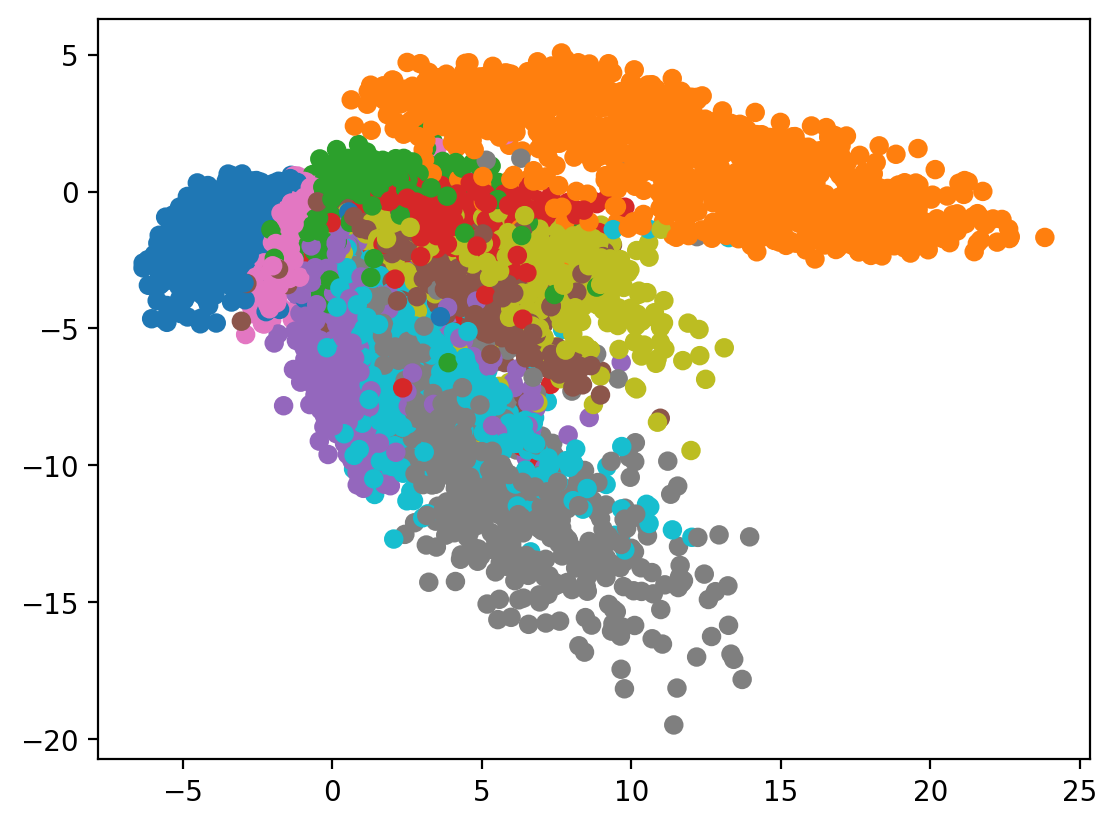

In [7]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

plot_latent(AE, test_loader)

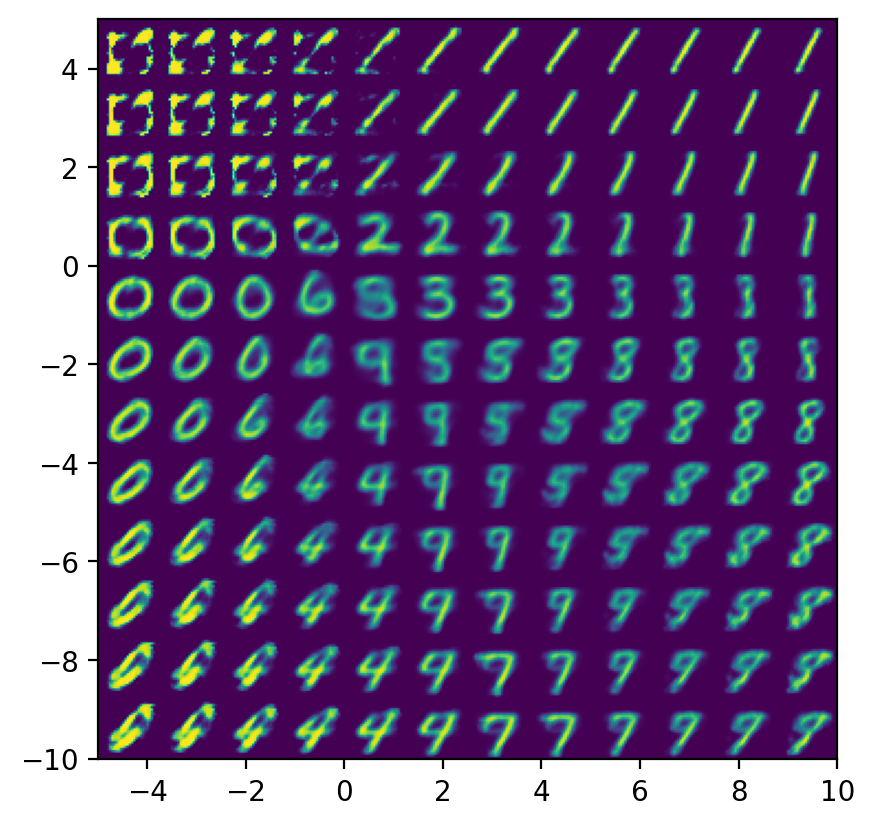

In [8]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()

plot_reconstructed(AE, r0=(-5, 10), r1=(-10, 5), n=12)

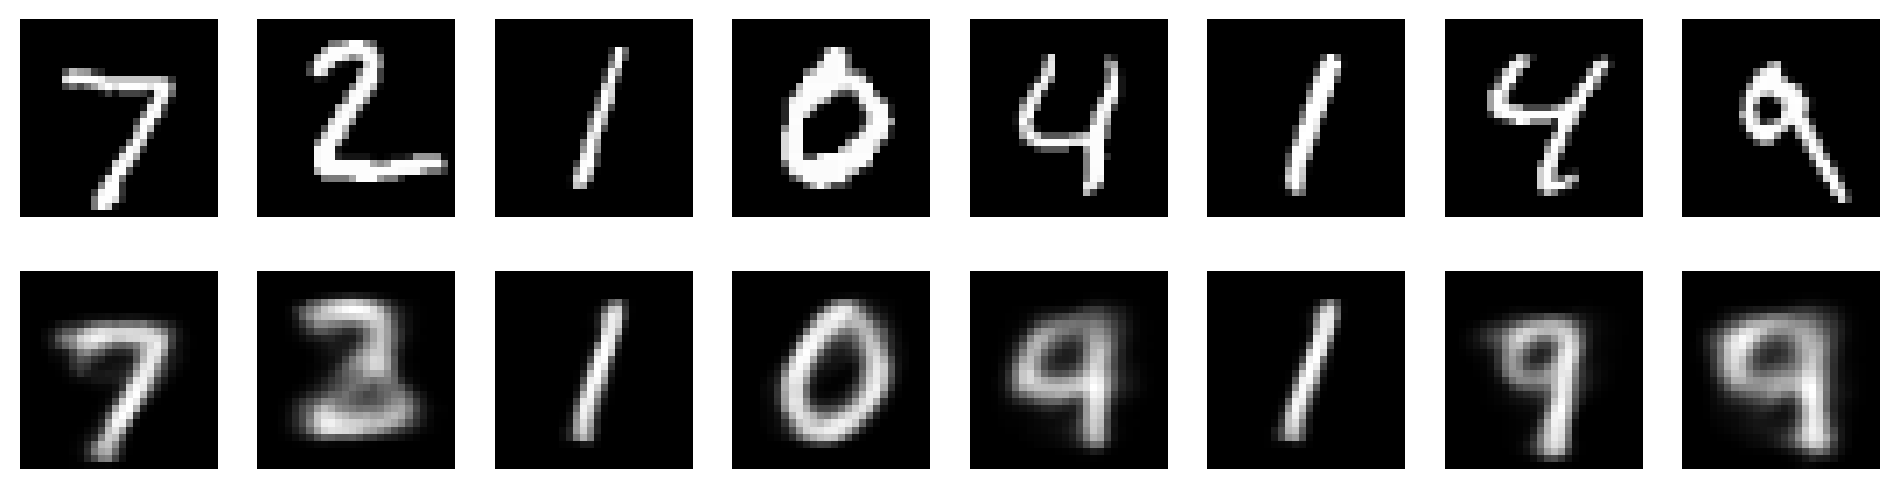

In [58]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data[:8].to(device)
    recon= AE(data)

    data = data.cpu()
    recon = recon.cpu()

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(data[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i][0], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.show()

In [64]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.fc_mean = nn.Linear(512, latent_dims)      # Mean head
        self.fc_logvar = nn.Linear(512, latent_dims)    # Log-variance head

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h = F.relu(self.linear1(x))
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        return z_mean, z_logvar
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [65]:
def loss_function(recon_x, x, mu, logvar):
    recon_x = recon_x.view(x.size(0), -1)
    x = x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + 0.05 * KLD

In [66]:
VAE = VariationalAutoencoder(latent_dims).to(device)
optimizer=torch.optim.Adam(VAE.parameters(), lr=1e-3)

In [67]:
for epoch in range(1, epochs + 1):
    VAE.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = VAE(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1, Average loss: 140.8673
Epoch 2, Average loss: 106.8275
Epoch 3, Average loss: 101.9809
Epoch 4, Average loss: 99.3610
Epoch 5, Average loss: 97.5810
Epoch 6, Average loss: 96.2315
Epoch 7, Average loss: 95.1870
Epoch 8, Average loss: 94.3158
Epoch 9, Average loss: 93.5724
Epoch 10, Average loss: 92.9357


In [68]:
VAE.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (fc_mean): Linear(in_features=512, out_features=8, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=8, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [1]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = mu + sigma*self.N.sample(mu.shape)
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

plot_latent(VAE, test_loader)

NameError: name 'VAE' is not defined

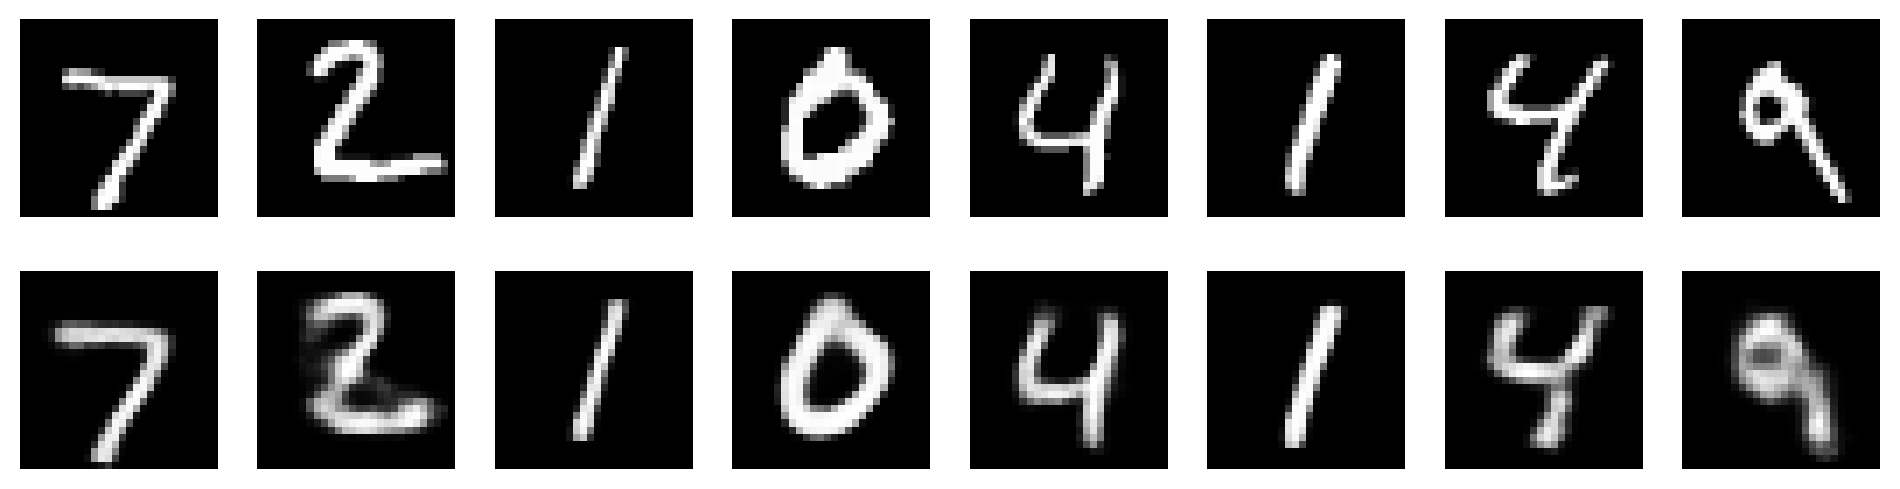

In [69]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data[:8].to(device)
    recon, _, _ = VAE(data)

    data = data.cpu()
    recon = recon.cpu()

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(data[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i][0], cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.show()

In [2]:
"""
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()

plot_reconstructed(VAE, r0=(-5, 10), r1=(-10, 5), n=12)
"""

"\ndef plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):\n    w = 28\n    img = np.zeros((n*w, n*w))\n    for i, y in enumerate(np.linspace(*r1, n)):\n        for j, x in enumerate(np.linspace(*r0, n)):\n            z = torch.Tensor([[x, y]]).to(device)\n            x_hat = autoencoder.decoder(z)\n            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()\n            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat\n    plt.imshow(img, extent=[*r0, *r1])\n    plt.show()\n\nplot_reconstructed(VAE, r0=(-5, 10), r1=(-10, 5), n=12)\n"

In [71]:
latents = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, logvar = VAE.encoder(x)
        z = VAE.reparameterize(mu, logvar)
        latents.append(z.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
z_pca = pca.fit_transform(latents)

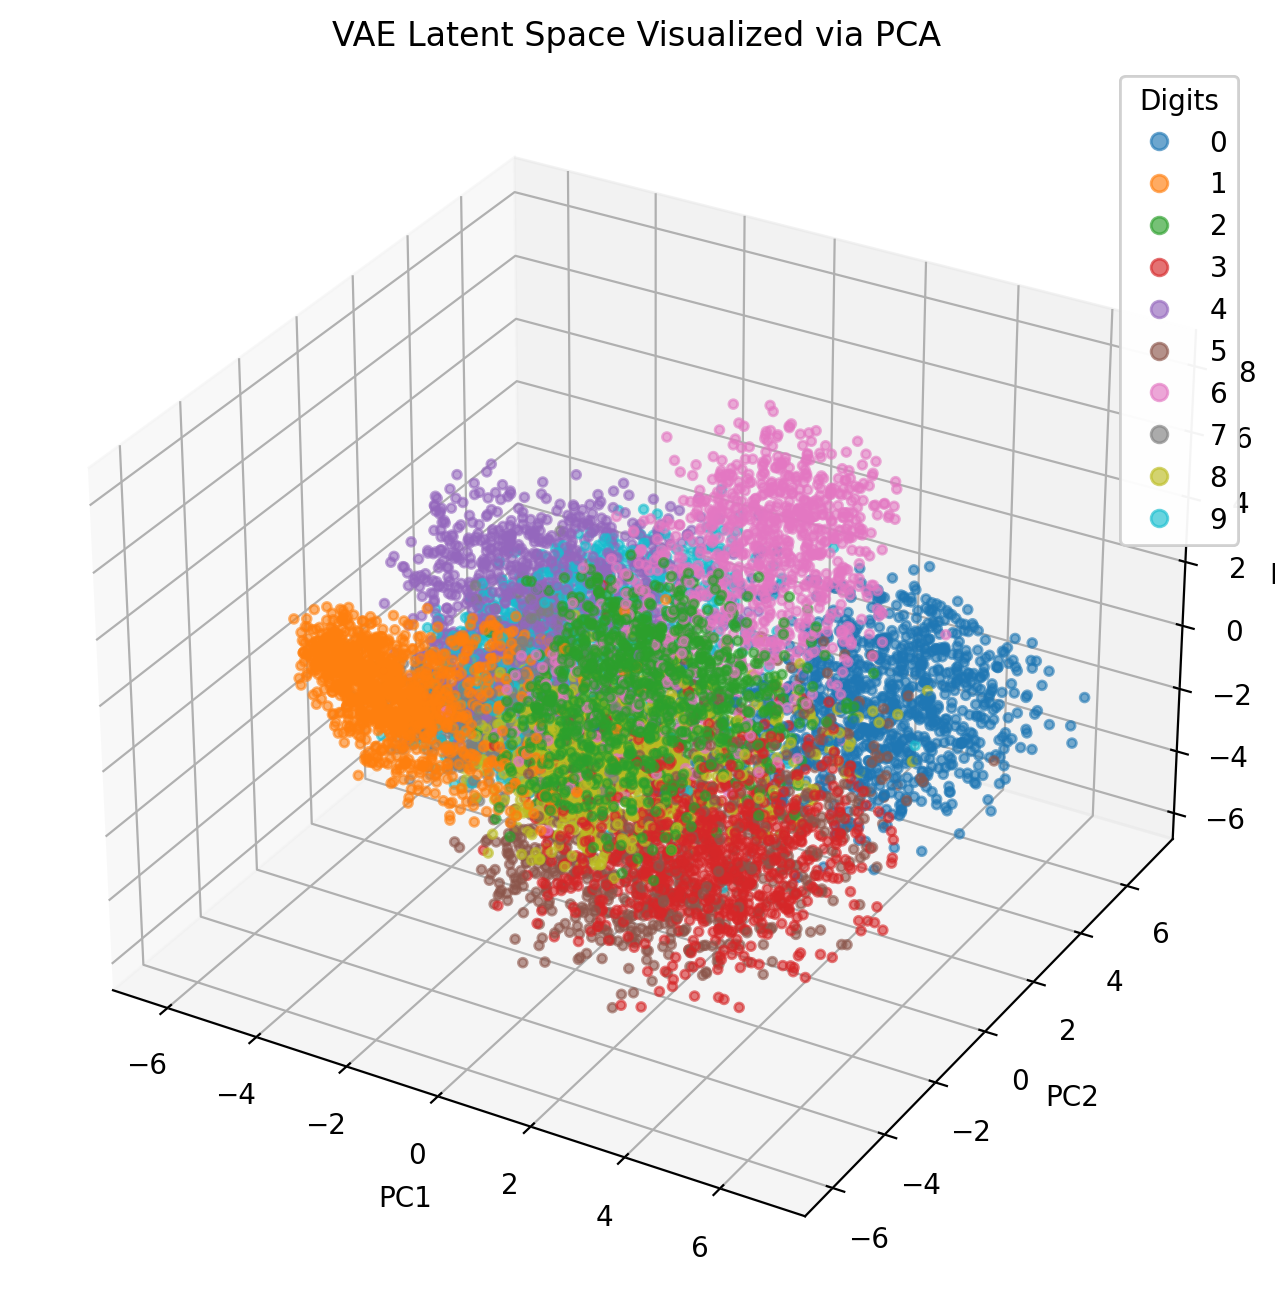

In [73]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(z_pca[:, 0], z_pca[:, 1], z_pca[:, 2], c=labels, cmap='tab10', alpha=0.6, s=10)
legend = ax.legend(*scatter.legend_elements(), title="Digits")
ax.add_artist(legend)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('VAE Latent Space Visualized via PCA')

plt.show()

In [74]:
import plotly.express as px
import pandas as pd

# Convert data to DataFrame
df = pd.DataFrame(z_pca, columns=['PC1', 'PC2', 'PC3'])
df['label'] = labels

fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color=df['label'].astype(str),
                    title="Interactive 3D PCA of VAE Latents", opacity=0.7)
fig.show()